In [1]:
!pip -q install scikit-learn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
print('TensorFlow:', tf.__version__)

TensorFlow: 2.19.0


In [2]:
import numpy as np

def synthetic_function(X: np.ndarray) -> np.ndarray:
    """
    X: shape (N, 3) with columns [x1, x2, x3]
    Returns y: shape (N, 1)
    """
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    y = np.sin(x1) + 0.3*(x2**2) - np.exp(-x3) + 0.1*x1*x2*x3
    return y.reshape(-1, 1)

def make_dataset(n=4000, seed=42, noise_std=0.05):
    rng = np.random.default_rng(seed)
    # bounded ranges so the function stays well-behaved
    x1 = rng.uniform(-3.0, 3.0, size=(n, 1))
    x2 = rng.uniform(-2.0, 2.0, size=(n, 1))
    x3 = rng.uniform(0.0, 4.0, size=(n, 1))
    X = np.concatenate([x1, x2, x3], axis=1)

    y = synthetic_function(X)
    y = y + rng.normal(0.0, noise_std, size=y.shape)
    return X.astype(np.float32), y.astype(np.float32)

def standardize_train_test(X, y, test_frac=0.2, seed=123):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    n_test = int(n * test_frac)
    test_idx, train_idx = idx[:n_test], idx[n_test:]
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    X_mean, X_std = Xtr.mean(axis=0, keepdims=True), Xtr.std(axis=0, keepdims=True) + 1e-8
    y_mean, y_std = ytr.mean(axis=0, keepdims=True), ytr.std(axis=0, keepdims=True) + 1e-8

    Xtr_n = (Xtr - X_mean) / X_std
    Xte_n = (Xte - X_mean) / X_std
    ytr_n = (ytr - y_mean) / y_std
    yte_n = (yte - y_mean) / y_std

    norms = dict(X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)
    return (Xtr_n, ytr_n, Xte_n, yte_n, norms)

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_loss(losses, title="Training loss"):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.show()

def plot_parity(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure()
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=8, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_4d_pca(X, y, title="4D plot: PCA(X)->3D, color=y"):
    # Reduce 3D inputs to 3 PCs (still 3D, but PCA helps decorrelate and looks nicer)
    # If you later use >3 inputs, PCA still gives a clean 3D view.
    pca = PCA(n_components=3)
    Xp = pca.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Xp[:,0], Xp[:,1], Xp[:,2], c=y.flatten(), s=8, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    fig.colorbar(sc, ax=ax, shrink=0.7, label="y (color)")
    plt.show()


Train: (4000, 3) (4000, 1)  Test: (1000, 3) (1000, 1)


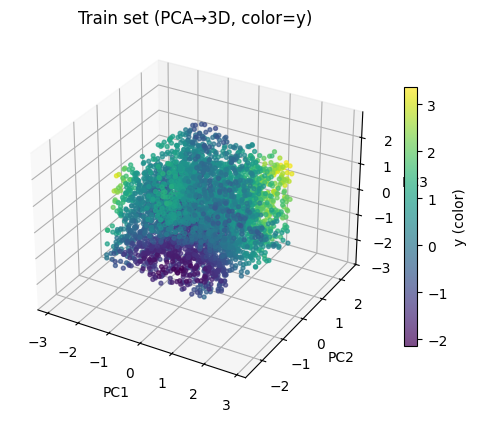

In [4]:
X, y = make_dataset(n=5000, seed=1, noise_std=0.05)
Xtr, ytr, Xte, yte, norms = standardize_train_test(X, y, test_frac=0.2, seed=2)

print("Train:", Xtr.shape, ytr.shape, " Test:", Xte.shape, yte.shape)
plot_4d_pca(Xtr, ytr, title="Train set (PCA→3D, color=y)")


In [5]:
def tanh(x):
    return np.tanh(x)

def dtanh(a):
    # derivative w.r.t. pre-activation z, but expressed using activation a=tanh(z)
    return 1.0 - a**2

class MLP3LayerManual:
    def __init__(self, d_in, h1, h2, d_out, seed=0):
        rng = np.random.default_rng(seed)
        # He/Xavier-ish init for tanh
        self.W1 = (rng.normal(0, 1, size=(d_in, h1)) / np.sqrt(d_in)).astype(np.float32)
        self.b1 = np.zeros((1, h1), dtype=np.float32)

        self.W2 = (rng.normal(0, 1, size=(h1, h2)) / np.sqrt(h1)).astype(np.float32)
        self.b2 = np.zeros((1, h2), dtype=np.float32)

        self.W3 = (rng.normal(0, 1, size=(h2, d_out)) / np.sqrt(h2)).astype(np.float32)
        self.b3 = np.zeros((1, d_out), dtype=np.float32)

        self.cache = {}

    def _einsum_mm(self, A, B):
        """
        Required: use tf.einsum instead of A@B.
        Accept numpy arrays, compute with tf.einsum, return numpy.
        """
        A_tf = tf.convert_to_tensor(A)
        B_tf = tf.convert_to_tensor(B)
        C_tf = tf.einsum("bi,io->bo", A_tf, B_tf)  # (batch,in) x (in,out) -> (batch,out)
        return C_tf.numpy()

    def forward(self, X):
        z1 = self._einsum_mm(X, self.W1) + self.b1
        a1 = tanh(z1)
        z2 = self._einsum_mm(a1, self.W2) + self.b2
        a2 = tanh(z2)
        z3 = self._einsum_mm(a2, self.W3) + self.b3
        yhat = z3  # linear output for regression

        self.cache = dict(X=X, z1=z1, a1=a1, z2=z2, a2=a2, z3=z3, yhat=yhat)
        return yhat

    def mse(self, yhat, y):
        return float(np.mean((yhat - y)**2))

    def backward(self, y):
        """
        Manual backprop via chain rule.
        """
        X = self.cache["X"]
        a1 = self.cache["a1"]
        a2 = self.cache["a2"]
        yhat = self.cache["yhat"]
        n = X.shape[0]

        # dL/dyhat = 2/N * (yhat - y)
        dY = (2.0 / n) * (yhat - y)  # (N,1)

        # Layer 3: yhat = a2 W3 + b3
        dW3 = self._einsum_mm(a2.T, dY)  # (h2,N) x (N,1) -> (h2,1)
        db3 = np.sum(dY, axis=0, keepdims=True)

        da2 = self._einsum_mm(dY, self.W3.T)  # (N,1) x (1,h2) -> (N,h2)
        dz2 = da2 * dtanh(a2)  # (N,h2)

        # Layer 2
        dW2 = self._einsum_mm(a1.T, dz2)  # (h1,N) x (N,h2) -> (h1,h2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = self._einsum_mm(dz2, self.W2.T)  # (N,h2) x (h2,h1) -> (N,h1)
        dz1 = da1 * dtanh(a1)  # (N,h1)

        # Layer 1
        dW1 = self._einsum_mm(X.T, dz1)  # (3,N) x (N,h1) -> (3,h1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = dict(dW1=dW1, db1=db1, dW2=dW2, db2=db2, dW3=dW3, db3=db3)
        return grads

    def step(self, grads, lr=1e-2):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]
        self.W3 -= lr * grads["dW3"]
        self.b3 -= lr * grads["db3"]

Epoch  200 | train MSE: 0.283931
Epoch  400 | train MSE: 0.103587
Epoch  600 | train MSE: 0.063569
Epoch  800 | train MSE: 0.050730
Epoch 1000 | train MSE: 0.043361
Epoch 1200 | train MSE: 0.038031
Epoch 1400 | train MSE: 0.033787


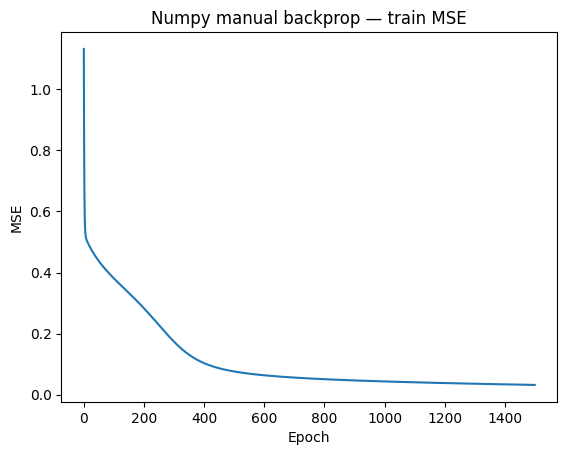

In [6]:
model = MLP3LayerManual(d_in=3, h1=64, h2=64, d_out=1, seed=7)

epochs = 1500
lr = 0.02
losses = []

for epoch in range(epochs):
    yhat = model.forward(Xtr)
    loss = model.mse(yhat, ytr)
    grads = model.backward(ytr)
    model.step(grads, lr=lr)
    losses.append(loss)

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1:4d} | train MSE: {loss:.6f}")

plot_loss(losses, title="Numpy manual backprop — train MSE")


Test MSE (denormalized): 0.031012339517474174


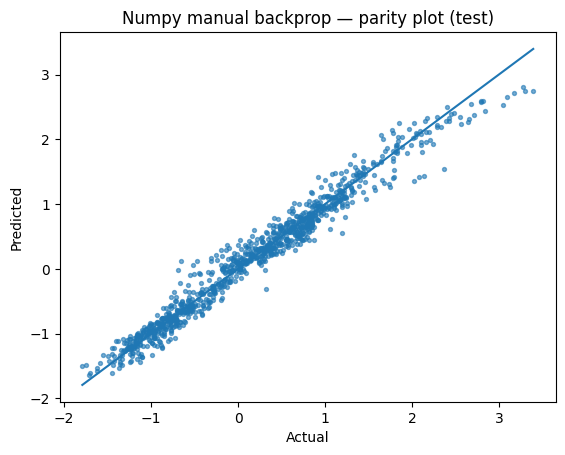

In [7]:
yhat_te = model.forward(Xte)
# denormalize
yhat_te_den = yhat_te * norms["y_std"] + norms["y_mean"]
yte_den = yte * norms["y_std"] + norms["y_mean"]

test_mse = np.mean((yhat_te_den - yte_den)**2)
print("Test MSE (denormalized):", float(test_mse))

plot_parity(yte_den, yhat_te_den, title="Numpy manual backprop — parity plot (test)")